# Logistic Regression Model

In [1]:
!pip install imblearn

In [2]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score


# Import data from DB for modeling

In [3]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [4]:
results = client.census_DB.census.find()
cluster_data = []
for result in results:
    del result['_id']
    cluster_data.append(result)

In [5]:
cleaned_census_data = pd.DataFrame(cluster_data)
cleaned_census_data

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican
...,...,...,...,...,...,...,...,...,...,...
9002,2020,MINNESOTA,MN,RENVILLE,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9003,2020,MINNESOTA,MN,ROSEAU,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9004,2020,MINNESOTA,MN,SHERBURNE,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9005,2020,MINNESOTA,MN,STEELE,36710.0,39.2,68172.0,34648.0,7.864342,Republican


# Data Cleaning

In [6]:
# Dropping the unwanted columns before performing the Machine Learning model
cleaned_census_data1 = cleaned_census_data.drop(['state','state_po', 'county_name'], axis=1)
cleaned_census_data1.head()

,year,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,9140.0,43.1,44885.0,21883.0,14.070022,Republican


In [7]:
# reading the winner counts for seeing data balance
cleaned_census_data1['Winner'].value_counts()

Republican    7415
Democrat      1592
Name: Winner, dtype: int64

<AxesSubplot:>

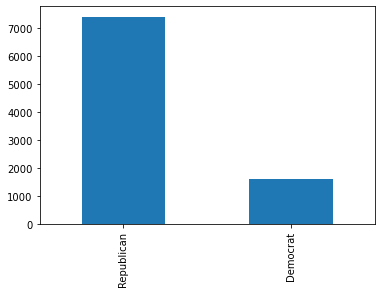

In [8]:
# visualizing the winner counts for seeing data balance
cleaned_census_data1['Winner'].value_counts().plot(kind='bar')

In [9]:
# making the target column as a binary indicator , so that I can utilize it in the Logistic Regression ML
winner_dict = {'Republican': 0, 'Democrat': 1}
cleaned_census_data1 = cleaned_census_data1.replace({'Winner': winner_dict})
cleaned_census_data1.head()

,year,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,12668.0,43.0,39028.0,20968.0,13.245974,0
1,2012,40330.0,39.6,34148.0,17763.0,20.300025,0
2,2012,52964.0,29.7,47960.0,21375.0,15.246205,0
3,2012,35507.0,39.1,39101.0,19788.0,18.244290,0
4,2012,9140.0,43.1,44885.0,21883.0,14.070022,0


# Build Logistic Regression Model

In [10]:
# selecting the Target and features for performing ML
# target = 'Winner'
# features = ['year','Population','Median Age','Household Income','Per Capita Income','Poverty Rate']
# print(features)
X = cleaned_census_data1[['Population','Median Age','Household Income','Per Capita Income','Poverty Rate']]
y = cleaned_census_data1['Winner']
print(X)
print(y)

      Population  Median Age  Household Income  Per Capita Income  \
0        12668.0        43.0           39028.0            20968.0   
1        40330.0        39.6           34148.0            17763.0   
2        52964.0        29.7           47960.0            21375.0   
3        35507.0        39.1           39101.0            19788.0   
4         9140.0        43.1           44885.0            21883.0   
...          ...         ...               ...                ...   
9002     14572.0        44.0           58542.0            31243.0   
9003     15259.0        41.6           62304.0            31452.0   
9004     96015.0        36.1           88671.0            36022.0   
9005     36710.0        39.2           68172.0            34648.0   
9006     24603.0        43.9           54502.0            26427.0   

      Poverty Rate  
0        13.245974  
1        20.300025  
2        15.246205  
3        18.244290  
4        14.070022  
...            ...  
9002      9.422180  
900

In [11]:
# Split our data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=1)

In [12]:
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (6755, 5)
Number transactions y_train dataset:  (6755,)
Number transactions X_test dataset:  (2252, 5)
Number transactions y_test dataset:  (2252,)


In [13]:
# create a logistic regression model

classifier = LogisticRegression()
classifier

LogisticRegression()

In [14]:
# Fit(train) our model by using the training data
classifier.fit(X_train, y_train)

LogisticRegression()

In [15]:
# Indicating how far my training and test data are accurately performing
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8540340488527017
Testing Data Score: 0.855683836589698


In [16]:
# logistic regression object
lr = LogisticRegression()
  
# train the model on train set
lr.fit(X_train, y_train.ravel())
  
predictions = lr.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1854
           1       0.81      0.24      0.37       398

    accuracy                           0.86      2252
   macro avg       0.84      0.61      0.64      2252
weighted avg       0.85      0.86      0.82      2252



The accuracy comes out to be 86% but did you notice something strange ?
The recall of the minority class('Democrat') in very less. It proves that the model is more biased towards majority class. So, it proves that this is not the best model.

In [17]:
y_true = y_test
y_pred = classifier.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[1832,   22],
       [ 303,   95]], dtype=int64)

<AxesSubplot:>

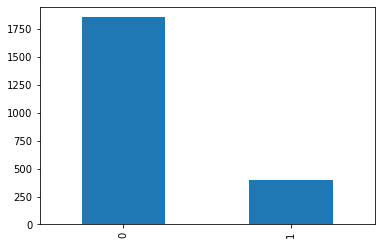

In [18]:
y_true.value_counts().plot(kind='bar')

In [19]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn) # (111 + 128) / (111 + 5 + 128 + 6)
print(f"Accuracy: {accuracy}")

Accuracy: 0.855683836589698


# create the confusion Matrix

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1854
           1       0.81      0.24      0.37       398

    accuracy                           0.86      2252
   macro avg       0.84      0.61      0.64      2252
weighted avg       0.85      0.86      0.82      2252

ROC AUC score: 0.613


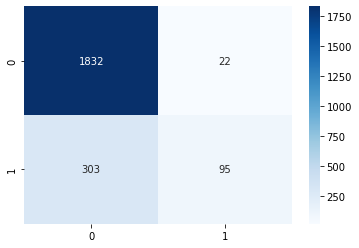

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
# Compute and print the classification report
cr = classification_report(y_true, y_pred)
print("Classification report:")
print(cr)
# Compute the ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC AUC score: {roc_auc:.3f}")

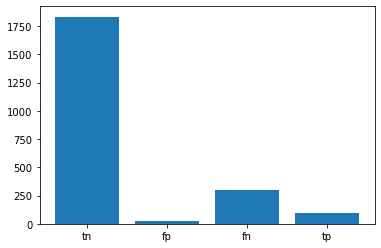

In [21]:
x = ['tn', 'fp', 'fn', 'tp']
y= [tn, fp, fn, tp]
plt.bar(x,y)
plt.show()


The accuracy comes out to be 86% but did you notice something strange? 
The recall of the minority class('Democrat') in very less. It proves that the model is more biased towards majority class('Republican'). So, it proves that this is not the best model.
Now, we will apply different imbalanced data handling techniques and see their accuracy and recall results.

# Using SMOTE Algorithm

In [22]:

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 1194
Before OverSampling, counts of label '0': 5561 

After OverSampling, the shape of train_X: (11122, 5)
After OverSampling, the shape of train_y: (11122,) 

After OverSampling, counts of label '1': 5561
After OverSampling, counts of label '0': 5561


SMOTE Algorithm has oversampled the minority instances and made it equal to majority class('Republican'). Both categories have equal amount of records. More specifically, the minority class('Democrat') has been increased to the total number of majority class.
Now see the accuracy and recall results after applying SMOTE algorithm (Oversampling).

# Prediction and Recall

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1854
           1       0.43      0.64      0.52       398

    accuracy                           0.79      2252
   macro avg       0.67      0.73      0.69      2252
weighted avg       0.83      0.79      0.80      2252



<AxesSubplot:>

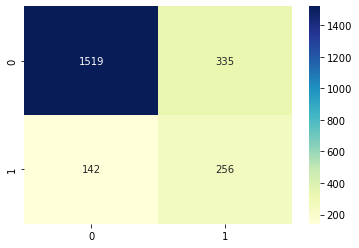

In [23]:
lr1 = LogisticRegression()
lr1.fit(X_train_res, y_train_res.ravel())
predictions = lr1.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)
# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='g')

We have reduced the accuracy to 79% as compared to previous model but the recall value of minority class('Democrat') has also improved to 64 %. This is a good model compared to the previous one. Recall is great.
Now, we will apply NearMiss technique to Under-sample the majority class and see its accuracy and recall results.

# NearMiss Algorithm:

In [24]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()
  
X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 1194
Before Undersampling, counts of label '0': 5561 

After Undersampling, the shape of train_X: (2388, 5)
After Undersampling, the shape of train_y: (2388,) 

After Undersampling, counts of label '1': 1194
After Undersampling, counts of label '0': 1194


The NearMiss Algorithm has undersampled the majority instances and made it equal to majority class('Republican'). Here, the majority class('Republican') has been reduced to the total number of minority class('Democrat'), so that both classes will have equal number of records.

# Prediction and Recall

              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1854
           1       0.32      0.73      0.44       398

    accuracy                           0.68      2252
   macro avg       0.62      0.70      0.61      2252
weighted avg       0.81      0.68      0.71      2252



<AxesSubplot:>

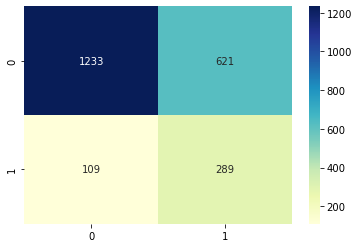

In [25]:
# train the model on train set
lr2 = LogisticRegression()
lr2.fit(X_train_miss, y_train_miss.ravel())
predictions = lr2.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)
# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='g')

This model is not better than the SMOTE model because it classifies worse and though the recall value of minority class('Democrat') is 73 %. But due to undersampling of majority class('Republican'), its recall has decreased to 67 %. So in this case, SMOTE is giving a great accuracy and recall. 

### SMOTE model will be a preferred model for this situation.

# Logistic Regression End